# Introduction

Ce notebook fait suite à celui sur l'apprentissage non supervisé.

Nous proposons ici de reprendre le traitement des images avec l'approche CNN mais, une fois les représentations construites, d'utiliser une classification supervisée plutot qu'un kmeans.

Pour cela, nous allons compléter le réseau de neurones en lui ajoutant des couches de classification.

Reprenons l'environnement d'exécution du notebook précédent : téléchargement des données, importation des librairies et utilisation d'un GPU.

In [1]:
!wget https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Textimage+DAS+V2/Dataset+projet+pre%CC%81traitement+textes+images.zip
!unzip Dataset+projet+prétraitement+textes+images.zip > /dev/null

--2024-04-16 15:06:55--  https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Textimage+DAS+V2/Dataset+projet+pre%CC%81traitement+textes+images.zip
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.90.211, 52.92.18.152, 52.92.35.216, ...
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.90.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 345072433 (329M) [application/zip]
Saving to: ‘Dataset+projet+prétraitement+textes+images.zip’

Dataset+projet+pre% 100%[===================>] 329.09M  21.0MB/s    in 17s     

2024-04-16 15:07:13 (19.7 MB/s) - ‘Dataset+projet+prétraitement+textes+images.zip’ saved [345072433/345072433]



In [2]:
import numpy as np
import pandas as pd

import time
import os

import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

from tensorflow.config import list_physical_devices

from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.applications import ResNet50

from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
print("Num GPUs Available: ", len(list_physical_devices("GPU")))

Num GPUs Available:  1


# Préparation des données

Nous avons seulement besoin d'extraire les catégories et de les associer aux images.

In [4]:
csv_file_path = "Flipkart/flipkart_com-ecommerce_sample_1050.csv"
img_dir_path = "Flipkart/Images"

data = pd.read_csv(csv_file_path)

In [5]:
def extract_category(tree) :
    end_index = tree.find(">") - 1
    return tree[2 : end_index]

df = data[["image", "product_category_tree"]].copy()
df["category"] = df["product_category_tree"].apply(extract_category)
df.drop(columns = ["product_category_tree"], inplace = True)

df.head()

,image,category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing


In [6]:
categories = df["category"].unique().tolist()
print("--- Catégories ---")
for i in range(len(categories)) :
    print(f"{i + 1}. {categories[i]}")

--- Catégories ---
1. Home Furnishing
2. Baby Care
3. Watches
4. Home Decor & Festive Needs
5. Kitchen & Dining
6. Beauty and Personal Care
7. Computers


In [7]:
image_path = os.path.join(img_dir_path, df.loc[677, "image"])
image = Image.open(image_path)
new_size = (image.width // 3, image.height // 3)
resized_image = image.resize(new_size)
resized_image.save(image_path)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Pour finir, séparons les données en un jeu d'entraînement et un jeu de test.<br>
On utilise un **stratify** pour s'assurer que la distribution des catégories est similaire dans les deux jeux.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    df["image"],
    df["category"],
    test_size = 0.2,
    random_state = 42,
    stratify = df["category"]
)

train_df = pd.DataFrame({"image": X_train, "category": y_train})
test_df = pd.DataFrame({"image" : X_test, "category": y_test})

# Base de convolution

Dans le notebook précédent, nous avions utilisé deux réseaux de neurones convolutionnels : VGG16 et ResNet50.<br>
Reprenons la fonctions qui permettait de calculer les représentations.

In [9]:
def extract_features(directory, dataframe, conv_base, batch_size) :

    datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

    generator = datagen.flow_from_dataframe(
        dataframe = dataframe,
        directory = directory,
        x_col = "image",
        y_col = "category",
        target_size = (224, 224),
        batch_size = batch_size,
        class_mode = "sparse"
    )

    output_shape = conv_base.layers[-1].output_shape
    sample_shape = (len(dataframe), *output_shape[1:])

    features = np.zeros(shape = sample_shape)
    labels = np.zeros(shape = sample_shape[0])

    for i in range(len(generator)) :
        (inputs_batch, labels_batch) = generator[i]
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        if (i + 1) * batch_size >= sample_shape[0] :
            break

    return features, labels

Ajoutons une fonction qui utilise la précédente sur notre jeu d'entraînement et notre jeu de test.

In [10]:
def apply_conv_base(conv_base, train_df, test_df, batch_size) :

    output = {}

    output["train_features"], output["train_labels"] = extract_features(
        directory = "Flipkart/Images",
        dataframe = train_df,
        conv_base = conv_base,
        batch_size = batch_size
    )

    output["test_features"], output["test_labels"] = extract_features(
        directory = "Flipkart/Images",
        dataframe = test_df,
        conv_base = conv_base,
        batch_size = batch_size
    )

    return output

Appliquons l'ensemble à un VGG16 et un ResNet50.

In [11]:
vgg16 = VGG16(
    weights = "imagenet",
    include_top = False,
    input_shape = (224, 224, 3)
)

vgg16_output = apply_conv_base(vgg16, train_df, test_df, batch_size = 20)

58889256/58889256 [==============================] - 0s 0us/step
Found 840 validated image filenames belonging to 7 classes.
1/1 [==============================] - 0s 27ms/step
Found 210 validated image filenames belonging to 7 classes.
1/1 [==============================] - 3s 3s/step


In [12]:
resnet = ResNet50(
    weights = "imagenet",
    include_top = False,
    input_shape = (224, 224, 3)
)

resnet_output = apply_conv_base(resnet, train_df, test_df, batch_size = 20)

94765736/94765736 [==============================] - 1s 0us/step
Found 840 validated image filenames belonging to 7 classes.
1/1 [==============================] - 0s 27ms/step
Found 210 validated image filenames belonging to 7 classes.
1/1 [==============================] - 1s 1s/step


# Classification supervisée

Commençons par définir une fonction qui entraîne un modèle de classification `classifier` donné à un jeu de représentations `input`.<br>
On utilise l'optimiseur `RMSprop`, la fonction de perte `categorical_crossentropy` et la métrique `accuracy`.

In [13]:
def fit_classifier(input, classifier, num_classes, learning_rate, batch_size) :

    classifier.compile(
        optimizer = RMSprop(learning_rate = learning_rate),
        loss = "categorical_crossentropy",
        metrics = ["accuracy"]
    )

    train_labels_cat = to_categorical(input["train_labels"], num_classes)
    test_labels_cat = to_categorical(input["test_labels"], num_classes)

    history = classifier.fit(
        input["train_features"],
        train_labels_cat,
        epochs = 20,
        batch_size = batch_size,
        validation_data = (input["test_features"], test_labels_cat)
    )

    return history

Utilisons cette fonction à un ensemble de couches adapté aux représentations du VGG16.

In [14]:
classifier_vgg16 = Sequential()
classifier_vgg16.add(Flatten())
classifier_vgg16.add(Dense(256, activation = "relu"))
classifier_vgg16.add(Dropout(0.5))
classifier_vgg16.add(Dense(len(categories), activation = "softmax"))

history_vgg16 = fit_classifier(
    input = vgg16_output,
    classifier = classifier_vgg16,
    num_classes = len(categories),
    learning_rate = 2e-5,
    batch_size = 20
)

Epoch 1/20
42/42 [==============================] - 2s 11ms/step - loss: 16.3973 - accuracy: 0.3369 - val_loss: 5.4302 - val_accuracy: 0.5714
Epoch 2/20
42/42 [==============================] - 0s 5ms/step - loss: 7.1133 - accuracy: 0.5774 - val_loss: 4.2038 - val_accuracy: 0.6810
Epoch 3/20
42/42 [==============================] - 0s 6ms/step - loss: 3.9430 - accuracy: 0.7143 - val_loss: 3.9059 - val_accuracy: 0.7143
Epoch 4/20
42/42 [==============================] - 0s 6ms/step - loss: 2.6262 - accuracy: 0.7738 - val_loss: 3.6425 - val_accuracy: 0.7190
Epoch 5/20
42/42 [==============================] - 0s 6ms/step - loss: 1.9748 - accuracy: 0.8202 - val_loss: 3.4420 - val_accuracy: 0.7524
Epoch 6/20
42/42 [==============================] - 0s 5ms/step - loss: 1.2907 - accuracy: 0.8655 - val_loss: 3.3726 - val_accuracy: 0.7571
Epoch 7/20
42/42 [==============================] - 0s 7ms/step - loss: 0.9828 - accuracy: 0.8940 - val_loss: 3.4651 - val_accuracy: 0.7762
Epoch 8/20
42/42 [

Faisons de même avec un ensemble de couches adapté aux représentations du ResNet50.

In [15]:
classifier_resnet = Sequential()
classifier_resnet.add(GlobalAveragePooling2D())
classifier_resnet.add(Dense(256, activation = "relu"))
classifier_resnet.add(Dense(len(categories), activation = "softmax"))

history_resnet = fit_classifier(
    input = resnet_output,
    classifier = classifier_resnet,
    num_classes = len(categories),
    learning_rate = 2e-5,
    batch_size = 20
)

Epoch 1/20
42/42 [==============================] - 1s 18ms/step - loss: 1.8890 - accuracy: 0.2500 - val_loss: 1.6088 - val_accuracy: 0.3905
Epoch 2/20
42/42 [==============================] - 0s 10ms/step - loss: 1.3138 - accuracy: 0.5869 - val_loss: 1.2560 - val_accuracy: 0.5952
Epoch 3/20
42/42 [==============================] - 0s 8ms/step - loss: 0.9858 - accuracy: 0.7274 - val_loss: 1.0427 - val_accuracy: 0.6667
Epoch 4/20
42/42 [==============================] - 0s 7ms/step - loss: 0.7878 - accuracy: 0.7857 - val_loss: 0.9065 - val_accuracy: 0.7381
Epoch 5/20
42/42 [==============================] - 0s 8ms/step - loss: 0.6592 - accuracy: 0.8190 - val_loss: 0.8162 - val_accuracy: 0.7714
Epoch 6/20
42/42 [==============================] - 0s 8ms/step - loss: 0.5691 - accuracy: 0.8488 - val_loss: 0.7545 - val_accuracy: 0.7857
Epoch 7/20
42/42 [==============================] - 0s 8ms/step - loss: 0.5029 - accuracy: 0.8655 - val_loss: 0.7140 - val_accuracy: 0.7952
Epoch 8/20
42/42 [

Affichons les courbes d'apprentissage (loss et accuracy) des deux modèles sur les jeux d'entraînement et de test.

In [16]:
def plot_learning_curves(history, model_name) :

    # Accuracy by epoch on train and test
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title(f"{model_name} : Model accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Test"], loc = "upper left")
    plt.show()

    # Loss by epoch on train and test
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title(f"{model_name} : Model loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Test"], loc = "upper left")
    plt.show()

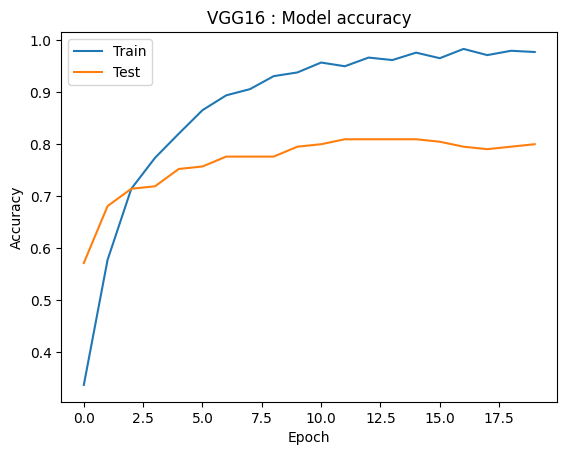

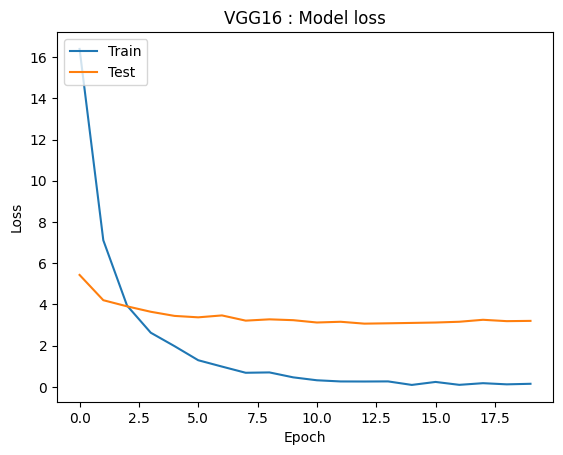

In [17]:
plot_learning_curves(history_vgg16, "VGG16")

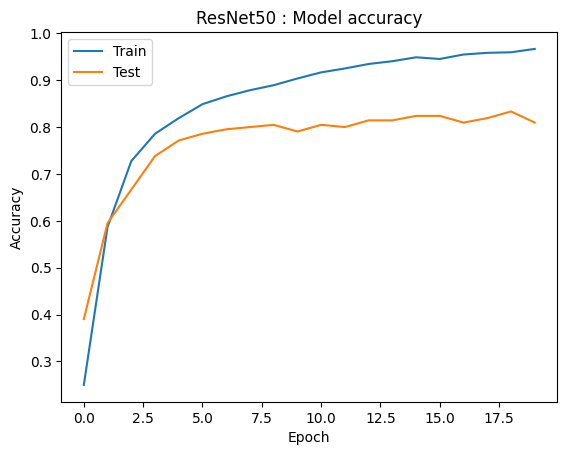

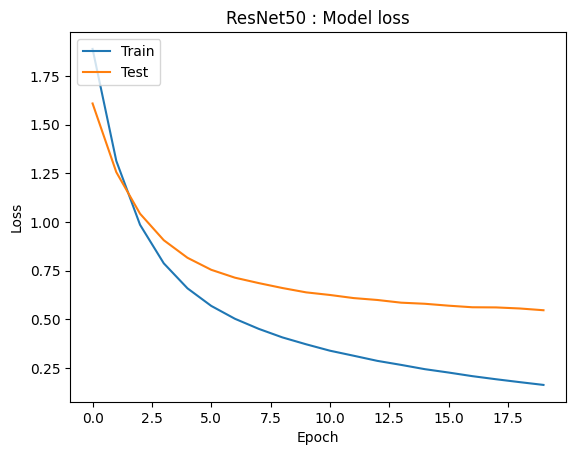

In [18]:
plot_learning_curves(history_resnet, "ResNet50")

L'accuracy est logiquement très élevée sur le jeu d'entraînement.<br>
Elle est un peu moindre mais néanmoins satisfaisante sur le jeu de test : les modèles généralisent bien.

# Comparaison de modèles

Dans cette section, on propose de mener quelques tests supplémentaires en jouant sur deux hyperparamètres :
- La vitesse d'apprentissage (0.001 ou 0.0001).
- La taille des batches (16 ou 32).

Commençons par préparer une table pour enregistrer les résultats.

In [19]:
cols = ["conv_base", "learning_rate", "batch_size", "accuracy", "val_accuracy",
        "loss", "val_loss", "time_conv_base", "time_classifier"]

models = pd.DataFrame(columns = cols, index = range(8))

for i in range(8) :
    models.at[i, "conv_base"] = "VGG16" if i % 8 < 4 else "ResNet50"
    models.at[i, "learning_rate"] = 0.0001 if i % 4 < 2 else 0.001
    models.at[i, "batch_size"] = 16 if i % 2 == 0 else 32

display(models)

,conv_base,learning_rate,batch_size,accuracy,val_accuracy,loss,val_loss,time_conv_base,time_classifier
0,VGG16,0.0001,16,NaN,NaN,NaN,NaN,NaN,NaN
1,VGG16,0.0001,32,NaN,NaN,NaN,NaN,NaN,NaN
2,VGG16,0.001,16,NaN,NaN,NaN,NaN,NaN,NaN
3,VGG16,0.001,32,NaN,NaN,NaN,NaN,NaN,NaN
4,ResNet50,0.0001,16,NaN,NaN,NaN,NaN,NaN,NaN
5,ResNet50,0.0001,32,NaN,NaN,NaN,NaN,NaN,NaN
6,ResNet50,0.001,16,NaN,NaN,NaN,NaN,NaN,NaN
7,ResNet50,0.001,32,NaN,NaN,NaN,NaN,NaN,NaN


Définissons une fonction qui encapsule l'application de la base de convolution des couches de classification.

In [20]:
def evaluate(train_df, test_df, conv_base, classifier, num_classes, model) :

    # Application de la base de convolution
    start_time = time.time()

    conv_base_output = apply_conv_base(
        conv_base = conv_base,
        train_df = train_df,
        test_df = test_df,
        batch_size = model["batch_size"]
    )

    model["time_conv_base"] = time.time() - start_time

    # Application de la classification supervisée
    start_time = time.time()

    history = fit_classifier(
        input = conv_base_output,
        classifier = classifier,
        num_classes = num_classes,
        learning_rate = model["learning_rate"],
        batch_size = model["batch_size"]
    )

    model["time_classifier"] = time.time() - start_time

    # Récupération des résultats
    model["accuracy"] = history.history["accuracy"][-1]
    model["val_accuracy"] = history.history["val_accuracy"][-1]
    model["loss"] = history.history["loss"][-1]
    model["val_loss"] = history.history["val_loss"][-1]

Appelons cette fonction sur chacun des modèles.

In [21]:
for (i, model) in models.iterrows() :

    if model["conv_base"] == "VGG16" :
        conv_base = vgg16
        classifier = classifier_vgg16
    else :
        conv_base = resnet
        classifier = classifier_resnet

    evaluate(train_df, test_df, conv_base, classifier, len(categories), model)

Found 840 validated image filenames belonging to 7 classes.
1/1 [==============================] - 2s 2s/step
Found 210 validated image filenames belonging to 7 classes.
1/1 [==============================] - 1s 1s/step
Epoch 1/20
53/53 [==============================] - 1s 8ms/step - loss: 0.2521 - accuracy: 0.9667 - val_loss: 3.0540 - val_accuracy: 0.7571
Epoch 2/20
53/53 [==============================] - 0s 5ms/step - loss: 0.2263 - accuracy: 0.9714 - val_loss: 3.3940 - val_accuracy: 0.7714
Epoch 3/20
53/53 [==============================] - 0s 6ms/step - loss: 0.1905 - accuracy: 0.9726 - val_loss: 3.9260 - val_accuracy: 0.7905
Epoch 4/20
53/53 [==============================] - 0s 5ms/step - loss: 0.2079 - accuracy: 0.9690 - val_loss: 3.3588 - val_accuracy: 0.8000
Epoch 5/20
53/53 [==============================] - 0s 5ms/step - loss: 0.1186 - accuracy: 0.9786 - val_loss: 3.6502 - val_accuracy: 0.7857
Epoch 6/20
53/53 [==============================] - 0s 5ms/step - loss: 0.1483 -

Affichons la table de résultats complétée.

In [22]:
display(models)

,conv_base,learning_rate,batch_size,accuracy,val_accuracy,loss,val_loss,time_conv_base,time_classifier
0,VGG16,0.0001,16,0.997619,0.780952,0.003648,4.256741,31.58116,6.622061
1,VGG16,0.0001,32,1.0,0.82381,0.000021,4.525836,30.378269,5.794272
2,VGG16,0.001,16,0.984524,0.828571,0.452127,14.126841,23.108475,10.876535
3,VGG16,0.001,32,0.991667,0.819048,0.215101,19.109297,18.561126,5.437506
4,ResNet50,0.0001,16,1.0,0.842857,0.000675,0.724941,25.140024,11.574921
5,ResNet50,0.0001,32,1.0,0.847619,0.000295,0.776028,23.401796,11.736687
6,ResNet50,0.001,16,1.0,0.842857,0.000005,1.500604,23.56052,11.629256
7,ResNet50,0.001,32,1.0,0.842857,0.000003,1.515936,18.70178,11.818919


Le meilleur modèle (accuracy sur le jeu de test) est le ResNet50 avec une vitesse d'entraînement à 0.0001 et une taille des batches à 32.

# Data Augmentation

Pour finir, essayons d'améliorer les performances avec de la **Data Augmentation**.<br>
C'est une technique qui augmente artificiellement le dataset en effectuant des transformations sur les images (rotations, symétries, etc.).

In [23]:
datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    horizontal_flip = True,
    fill_mode = "nearest"
)

train_generator = datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = "Flipkart/Images",
    x_col = "image",
    y_col = "category",
    target_size = (224, 224),
    batch_size = 20,
    class_mode = "categorical"
)


test_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input
)

validation_generator = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    directory = "Flipkart/Images",
    x_col = "image",
    y_col = "category",
    target_size = (224, 224),
    batch_size = 20,
    class_mode = "categorical",
    shuffle = False
)

Found 840 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


In [24]:
conv_base.trainable = False

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu', name='features'))
model.add(Dense(7, activation='softmax'))

model.compile(loss = "categorical_crossentropy",
              optimizer = RMSprop(learning_rate = 0.001),
              metrics = ["accuracy"])

In [25]:
batch_size = 16

history = model.fit(
    train_generator,
    steps_per_epoch = vgg16_output["train_features"].shape[0] // batch_size,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = vgg16_output["test_features"].shape[0] // batch_size,
    workers = 6
)

Epoch 1/20
52/52 [==============================] - 37s 591ms/step - loss: 24.1772 - accuracy: 0.6038 - val_loss: 3.3731 - val_accuracy: 0.7680
Epoch 2/20
52/52 [==============================] - 33s 592ms/step - loss: 2.8990 - accuracy: 0.8154 - val_loss: 4.0749 - val_accuracy: 0.7840
Epoch 3/20
52/52 [==============================] - 33s 605ms/step - loss: 2.0713 - accuracy: 0.8250 - val_loss: 4.1355 - val_accuracy: 0.7800
Epoch 4/20
52/52 [==============================] - 31s 560ms/step - loss: 1.4039 - accuracy: 0.8481 - val_loss: 3.7570 - val_accuracy: 0.8040
Epoch 5/20
52/52 [==============================] - 31s 539ms/step - loss: 0.9003 - accuracy: 0.8952 - val_loss: 2.3264 - val_accuracy: 0.8320
Epoch 6/20
52/52 [==============================] - 32s 554ms/step - loss: 0.8850 - accuracy: 0.8817 - val_loss: 1.9230 - val_accuracy: 0.7840
Epoch 7/20
52/52 [==============================] - 39s 693ms/step - loss: 0.5250 - accuracy: 0.9173 - val_loss: 2.5795 - val_accuracy: 0.796

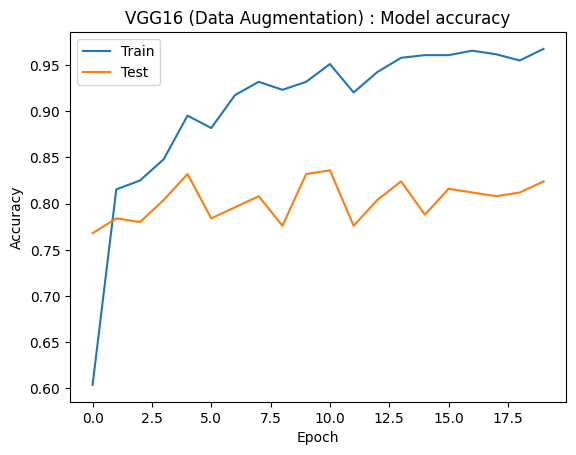

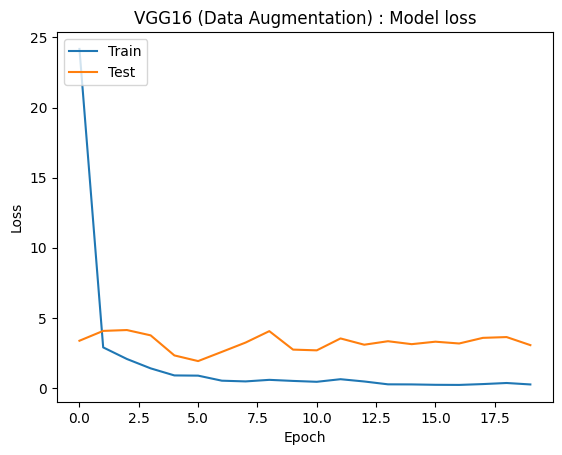

In [26]:
plot_learning_curves(history, "VGG16 (Data Augmentation)")

Les performances n'étant pas meilleures et la **Data Augmentation** étant particulièrement coûteuse en temps, il est raisonnable de s'en passer.